# Battle of the Neighborhoods

A peer-graded assignment on Coursera made by **Bach Khoi Vo**.

- - -
> This project aims to utilize all Data Science Concepts learned in the IBM Data Science Professional Course. We define a Business Problem, the data that will be utilized and using that data, we are able to analyze it using Machine Learning tools. In this project, we will go through all the processes in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.
- - -
## Table of Contents
1. Introduction
2. Data Overview
3. Data Processing
4. Machine Learning
5. Discussion
6. Conclusion

## Introduction (Identifying the Business Problem)
Toronto is one of the most densely populated areas in Canada. Being the land of opportunity, it brings in a variety of people from different ethnic backgrounds to the core city of Canada, Toronto. Being the largest city in Canada with an estimated population of over 6 million, there is no doubt about the diversity of the population. Multiculturalism is seen through the various neighbourhoods including; Chinatown, Corso Italia, Little India, Kensington Market, Little Italy, Koreatown and many more. Downtown Toronto being the hub of interactions between ethnicities brings many opportunities for entrepreneurs to start or grow their business. It is a place where people can try the best of each culture, either while they work or just passing through. Toronto is well known for its great food.

The objective of this project is to use Foursquare location data and regional clustering of venue information to determine what might be **the ‘best’ neighbourhood in Toronto to open a Vietnamese restaurant**. 

![](https://tophaiphong.com/wp-content/uploads/2020/07/quan-pho-ngon-Hai-Phong.jpg)

### Target Audience
This project is aimed towards Entrepreneurs or Business owners who want to open a new Vietnamese Restaurant or grow their current business. The analysis will provide vital information that can be used by the target audience

## Data Overview
The data that will be required will be a combination of CSV files that have been prepared for the purposes of the analysis from multiple sources which will provide the list of neighbourhoods in Toronto (via Wikipedia), the Geographical location of the neighbourhoods (via Geocoder package) and Venue data pertaining to Vietnamese restaurants (via Foursquare). The Venue data will help find which neighbourhood is best suitable to open an Italian restaurant.

### Data Acquisition
#### Source: Toronto Neighborhoods via Wikipedia
![](https://miro.medium.com/max/2400/1*jbicd7Qn2P4J08tZsH0lsw.jpeg)
The Wikipedia site shown above provided almost all the information about the neighbourhoods. It included the postal code, borough and the name of the neighbourhoods present in Toronto. Since the data is not in a format that is suitable for analysis, scraping of the data was done from this site
#### Source: Geographical Location data
![](https://miro.medium.com/max/680/1*Glxyl5AMUihAPDLuHPl8Fg.jpeg)
The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes. We will use the CSV file that acquired from previous lab.
#### Source: Venue Data using Foursquare
![](https://businessideaslab.com/wp-content/uploads/2016/03/foursquare-logo.jpg)
In this source, we will get Venue Data via Foursquare API.


In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

- - -
## Data Processing

### Preprocessing the Data

#### Get Toronto Neighborhoods Data from Wikipedia
I will get raw HTML source code from the Wikipedia, then store it to `source`. After that, by using BeautifulSoup, I extract contents such as: title, table, etc from the `source`.

In [2]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&diff=1012118802&oldid=1012023397'
source = requests.get(url=url).text
soup = BeautifulSoup(source, 'lxml')

I will try to find out all of the tables are in the raw data.

In [3]:
tables = soup.find('table', class_ = "wikitable sortable")
# print(tables.prettify())

Converting to the DataFrame

In [4]:
rows = []
columns = ['PostalCode', 'Borough', 'Neighborhood']
for row in tables.find_all('tr'):
    cols = row.find_all('td')
    rows.append([data.text for data in cols])
raw_df = pd.DataFrame(data=rows, columns=columns)
raw_df.head()

,PostalCode,Borough,Neighborhood
0,None,None,None
1,M1A\n,Not assigned\n,Not assigned\n
2,M2A\n,Not assigned\n,Not assigned\n
3,M3A\n,North York\n,Parkwoods\n
4,M4A\n,North York\n,Victoria Village\n


Cleaning the DataFrame

In [5]:
# Drop None & NoneAssigneed Cell
raw_df.dropna(axis=0, inplace=True)
raw_df = raw_df[raw_df['Borough']!='Not assigned\n']
raw_df = raw_df[raw_df['Neighborhood']!='Not assigned\n']
raw_df.head()

,PostalCode,Borough,Neighborhood
3,M3A\n,North York\n,Parkwoods\n
4,M4A\n,North York\n,Victoria Village\n
5,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"
6,M6A\n,North York\n,"Lawrence Manor, Lawrence Heights\n"
7,M7A\n,Downtown Toronto\n,"Queen's Park, Ontario Provincial Government\n"


In [6]:
# Removing '\n'
raw_df = raw_df.apply(lambda row: [col[:-1] for col in row], axis=0)
raw_df.reset_index(inplace=True, drop=True)
raw_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Finally, we got the cleaned data

In [7]:
df = raw_df.copy()
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,11,99
top,M5H,North York,Downsview
freq,1,24,4


Save the data to CSV file 

In [8]:
df.to_csv('Toronto_Neighborhoods.csv')

Load CSV file when restart work

In [4]:
df = pd.read_csv('Data/Toronto_Neighborhoods.csv', index_col=0)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


- - -
#### Get the latitude and the longitude coordinates of each neighborhood
Load the given `Geospatial Coordinates` dataset and join it with the origin.

In [5]:
df_geo = pd.read_csv('Data/Geospatial_Coordinates.csv')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Join two dataframe
df_toronto = pd.merge(df, df_geo, how='left', left_on='PostalCode', right_on='Postal Code')
df_toronto.head()

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,43.662301,-79.389494


In [7]:
df_toronto.drop('Postal Code', axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


- - -
###  Data Exploration
Before diving into the data, let's quickly examine dataframe

In [8]:
print(f'Toronto has {len(df_toronto["Borough"].unique())} boroughs and {df_toronto.shape[0]} neighborhoods.')

Toronto has 11 boroughs and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto City.¶

In [9]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


#### Create a map of the whole Toronto City with neighborhoods superimposed on top.

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version
For privacy, I will leave this field empty :D

In [11]:
CLIENT_ID = 'JYTGVLK2CM05CTQM11S3YMEYI1I4JYGPUBLOAW4U4S5KENJM' # your Foursquare ID
CLIENT_SECRET = '22JB0FCES5A0AOINYMOUEPFXV53I3TWFZQMABT1ENRZL2J2W' # your Foursquare Secret
VERSION = '20210617' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JYTGVLK2CM05CTQM11S3YMEYI1I4JYGPUBLOAW4U4S5KENJM
CLIENT_SECRET:22JB0FCES5A0AOINYMOUEPFXV53I3TWFZQMABT1ENRZL2J2W


- - - 
### Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _toronto_venues_.

In [13]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])
print('Done!')

Done!


Let's check the resulting dataframe

In [14]:
toronto_venues.shape

(2007, 7)

In [15]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Let's check how many venues were returned for each neighborhood.

In [16]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",15,15,15,15,15,15
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Willowdale, Willowdale East",28,28,28,28,28,28
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4


Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print(f'There are {toronto_venues["Venue Category"].unique().size} unique categories!')

There are 259 unique categories!


- - -
#### Analyze Each Neighborhood

In [18]:
# one hot encoding
toronto_venues_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_venues_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_venues_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
for x in toronto_venues_onehot.columns:
    print(x)

Accessories Store
Adult Boutique
Afghan Restaurant
Airport
Airport Food Court
Airport Gate
Airport Lounge
Airport Service
Airport Terminal
American Restaurant
Antique Shop
Aquarium
Art Gallery
Arts & Crafts Store
Asian Restaurant
Athletics & Sports
Auto Garage
Auto Workshop
BBQ Joint
Baby Store
Bagel Shop
Bakery
Bank
Bar
Baseball Field
Baseball Stadium
Basketball Court
Basketball Stadium
Beach
Bed & Breakfast
Beer Bar
Beer Store
Belgian Restaurant
Bistro
Board Shop
Boat or Ferry
Bookstore
Boutique
Brazilian Restaurant
Breakfast Spot
Brewery
Bridal Shop
Bubble Tea Shop
Burger Joint
Burrito Place
Bus Line
Bus Station
Business Service
Butcher
Café
Cajun / Creole Restaurant
Candy Store
Caribbean Restaurant
Cheese Shop
Chinese Restaurant
Chocolate Shop
Church
Climbing Gym
Clothing Store
Cocktail Bar
Coffee Shop
College Arts Building
College Auditorium
College Cafeteria
College Gym
College Rec Center
College Stadium
Colombian Restaurant
Comfort Food Restaurant
Comic Shop
Concert Hall
Constru

### Vietnamese Restaurant 

In [20]:
sample = toronto_venues_onehot.groupby('Neighborhood').sum().reset_index()
sample.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
sample = sample.sort_values(by='Vietnamese Restaurant', ascending=False)
sample['Vietnamese Restaurant'].head(10)

48    2
43    2
23    1
91    1
45    1
31    1
77    1
62    0
68    0
67    0
Name: Vietnamese Restaurant, dtype: uint8

Map Neighborhoods that have Vietnamese Restaurants

In [22]:
vnr_df = sample['Neighborhood'].head(7).to_frame().reset_index(drop=True)
vnr_df = pd.merge(vnr_df, df_toronto, left_on='Neighborhood', right_on='Neighborhood')
vnr_df

,Neighborhood,PostalCode,Borough,Latitude,Longitude
0,"Little Portugal, Trinity",M6J,West Toronto,43.647927,-79.419750
1,"Kensington Market, Chinatown, Grange Park",M5T,Downtown Toronto,43.653206,-79.400049
2,"Dorset Park, Wexford Heights, Scarborough Town...",M1P,Scarborough,43.757410,-79.273304
3,"Willowdale, Willowdale East",M2N,North York,43.770120,-79.408493
4,"Lawrence Manor, Lawrence Heights",M6A,North York,43.718518,-79.464763
5,"Garden District, Ryerson",M5B,Downtown Toronto,43.657162,-79.378937
6,"Summerhill West, Rathnelly, South Hill, Forest...",M4V,Central Toronto,43.686412,-79.400049


In [46]:
vnr_code = ['M6J', 'M5T', 'M1P', 'M2N', 'M6A', 'M5B', 'M4V']

In [23]:
# create map of Toronto using latitude and longitude values
map_vnr = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(vnr_df['Latitude'], vnr_df['Longitude'], vnr_df['Borough'], vnr_df['Neighborhood']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vnr)  
    
map_vnr

### Asia Restaurants

In [24]:
asia_columns = ['Neighborhood', 'Vietnamese Restaurant', 'Thai Restaurant', 'Ramen Restaurant','Asian Restaurant', 'Chinese Restaurant', 'Japanese Restaurant', 
                'Korean Restaurant', 'Korean BBQ Restaurant', 'Taiwanese Restaurant', 'Dim Sum Restaurant']

#### Frequency

In [78]:
toronto_grouped_mean = toronto_venues_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped_mean.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
asia_mean_df = toronto_grouped_mean.loc[:, asia_columns].reset_index(drop=True)
asia_mean_df.sum()

Neighborhood             AgincourtAlderwood, Long BranchBathurst Manor,...
Vietnamese Restaurant                                             0.503902
Thai Restaurant                                                   0.529661
Ramen Restaurant                                                  0.152294
Asian Restaurant                                                  0.273978
Chinese Restaurant                                                1.025862
Japanese Restaurant                                               1.001584
Korean Restaurant                                                 0.075099
Korean BBQ Restaurant                                                 0.25
Taiwanese Restaurant                                              0.025641
Dim Sum Restaurant                                                0.047619
dtype: object

#### Merge restaurants
Dim Sum Restaurant -> Chinese Restaurant

Korean BBQ -> Korean Restaurant

Ramen Restaurant -> Asia Restaurant

In [75]:
asia_mean_df.loc[asia_mean_df['Dim Sum Restaurant']>=1, 'Chinese Restaurant'] += asia_mean_df.loc[asia_mean_df['Dim Sum Restaurant']>=1, 'Dim Sum Restaurant']
asia_mean_df.loc[asia_mean_df['Korean BBQ Restaurant']>=1, 'Korean Restaurant'] += asia_mean_df.loc[asia_mean_df['Korean BBQ Restaurant']>=1, 'Korean BBQ Restaurant']
asia_mean_df.loc[asia_mean_df['Ramen Restaurant']>=1, 'Asian Restaurant'] += asia_mean_df.loc[asia_mean_df['Ramen Restaurant']>=1, 'Ramen Restaurant']
asia_mean_df.drop(['Dim Sum Restaurant', 'Korean BBQ Restaurant', 'Ramen Restaurant'], axis=1, inplace=True)
asia_mean_df.sum()

Neighborhood             AgincourtAlderwood, Long BranchBathurst Manor,...
Vietnamese Restaurant                                             0.503902
Thai Restaurant                                                   0.529661
Asian Restaurant                                                  0.273978
Chinese Restaurant                                                1.025862
Japanese Restaurant                                               1.001584
Korean Restaurant                                                 0.075099
Taiwanese Restaurant                                              0.025641
dtype: object

In [83]:
asia_mean_df.shape

(96, 8)

#### Count 

In [77]:
toronto_grouped_sum = toronto_venues_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped_sum.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
asia_sum_df = toronto_grouped_sum.loc[:, asia_columns].reset_index(drop=True)
asia_sum_df.head()

,Neighborhood,Vietnamese Restaurant,Thai Restaurant,Ramen Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Korean BBQ Restaurant,Taiwanese Restaurant,Dim Sum Restaurant
0,Agincourt,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,1,1,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,1,0,0,0,0,0,0,0,0


#### Merge restaurants
Dim Sum Restaurant -> Chinese Restaurant

Korean BBQ -> Korean Restaurant

Ramen Restaurant -> Asia Restaurant

In [80]:
asia_sum_df.loc[asia_sum_df['Dim Sum Restaurant']>=1, 'Chinese Restaurant'] += asia_sum_df.loc[asia_sum_df['Dim Sum Restaurant']>=1, 'Dim Sum Restaurant']
asia_sum_df.loc[asia_sum_df['Korean BBQ Restaurant']>=1, 'Korean Restaurant'] += asia_sum_df.loc[asia_sum_df['Korean BBQ Restaurant']>=1, 'Korean BBQ Restaurant']
asia_sum_df.loc[asia_sum_df['Ramen Restaurant']>=1, 'Asian Restaurant'] += asia_sum_df.loc[asia_sum_df['Ramen Restaurant']>=1, 'Ramen Restaurant']
asia_sum_df.drop(['Dim Sum Restaurant', 'Korean BBQ Restaurant', 'Ramen Restaurant'], axis=1, inplace=True)
asia_sum_df.sum()

Neighborhood             AgincourtAlderwood, Long BranchBathurst Manor,...
Vietnamese Restaurant                                                    9
Thai Restaurant                                                         17
Asian Restaurant                                                        26
Chinese Restaurant                                                      16
Japanese Restaurant                                                     45
Korean Restaurant                                                        4
Taiwanese Restaurant                                                     1
dtype: object

In [82]:
asia_sum_df.shape

(96, 8)

- - -

### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 3

for hood in asia_df['Neighborhood']:
    print("----"+hood+"----")
    temp = asia_df[asia_df['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                   venue  freq
0  Vietnamese Restaurant   0.0
1        Thai Restaurant   0.0
2       Asian Restaurant   0.0


----Alderwood, Long Branch----
                   venue  freq
0  Vietnamese Restaurant   0.0
1        Thai Restaurant   0.0
2       Asian Restaurant   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
                   venue  freq
0  Vietnamese Restaurant   0.0
1        Thai Restaurant   0.0
2       Asian Restaurant   0.0


----Bayview Village----
                   venue  freq
0     Chinese Restaurant  0.25
1    Japanese Restaurant  0.25
2  Vietnamese Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                   venue  freq
0        Thai Restaurant  0.04
1  Vietnamese Restaurant  0.00
2       Asian Restaurant  0.00


----Berczy Park----
                   venue  freq
0        Thai Restaurant  0.02
1    Japanese Restaurant  0.02
2  Vietnamese Restaurant  0.00


----Birch Cliff, Cliffside West----
                 

                   venue  freq
0    Japanese Restaurant  0.02
1  Vietnamese Restaurant  0.00
2        Thai Restaurant  0.00


----The Kingsway, Montgomery Road, Old Mill North----
                   venue  freq
0  Vietnamese Restaurant   0.0
1        Thai Restaurant   0.0
2       Asian Restaurant   0.0


----Thorncliffe Park----
                   venue  freq
0  Vietnamese Restaurant   0.0
1        Thai Restaurant   0.0
2       Asian Restaurant   0.0


----Toronto Dominion Centre, Design Exchange----
                 venue  freq
0     Asian Restaurant  0.04
1  Japanese Restaurant  0.03
2   Chinese Restaurant  0.01


----University of Toronto, Harbord----
                   venue  freq
0    Japanese Restaurant  0.06
1  Vietnamese Restaurant  0.00
2        Thai Restaurant  0.00


----Victoria Village----
                   venue  freq
0  Vietnamese Restaurant   0.0
1        Thai Restaurant   0.0
2       Asian Restaurant   0.0


----West Deane Park, Princess Gardens, Martin Grove, Islingt

###  Let's put that into a pandas dataframe

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = asia_df['Neighborhood']

for ind in np.arange(asia_df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(asia_df.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
1,"Alderwood, Long Branch",Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
3,Bayview Village,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant
4,"Bedford Park, Lawrence Manor East",Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant


## Machine Learning

### Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [33]:
asia_clustering = asia_df.drop('Neighborhood', axis=1)

In [34]:
def VisualizeElbowMethod(start, end):
    inertias = []
    for kclusters in range(start, end+1):
        kmeans = KMeans(n_clusters=kclusters, max_iter=100, random_state=10).fit(asia_clustering)
        inertias.append(kmeans.inertia_)
    sns.lineplot(x=range(start, end+1), y=inertias)
    plt.title('Elbow Method For Choosing Optimal K')
    plt.xlabel('K')
    plt.ylabel('Inertia')

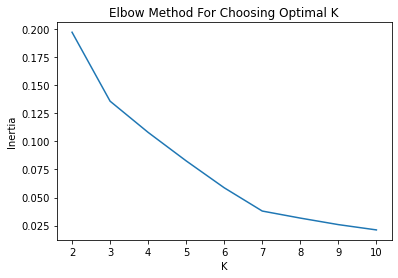

In [37]:
VisualizeElbowMethod(2, 10)

In [38]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, max_iter=500).fit(asia_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
    

array([0, 0, 0, 2, 3, 0, 0, 4, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [39]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [40]:
asia_merged = df_toronto

asia_merged = asia_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

asia_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Asian Restaurant,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant,Japanese Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,6.0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4.0,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant


In [41]:
asia_merged.dropna(axis=0, inplace=True)

In [42]:
asia_merged['Cluster Labels'] = asia_merged['Cluster Labels'].astype('int64')

Finally, let's visualize the resulting clusters

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(asia_merged['Latitude'], asia_merged['Longitude'], asia_merged['Neighborhood'], asia_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
asia_merged.groupby('Cluster Labels').count()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Cluster Labels,,,,,,,,,,
0,69,69,69,69,69,69,69,69,69,69
1,4,4,4,4,4,4,4,4,4,4
2,1,1,1,1,1,1,1,1,1,1
3,5,5,5,5,5,5,5,5,5,5
4,18,18,18,18,18,18,18,18,18,18
5,1,1,1,1,1,1,1,1,1,1
6,2,2,2,2,2,2,2,2,2,2


In [47]:
asia_merged[asia_merged['PostalCode'].isin(vnr_code)]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,6,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Thai Restaurant,Japanese Restaurant,Vietnamese Restaurant,Chinese Restaurant,Asian Restaurant
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,4,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant,Korean Restaurant,Thai Restaurant
59,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,4,Japanese Restaurant,Vietnamese Restaurant,Korean Restaurant,Thai Restaurant,Asian Restaurant
65,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,5,Vietnamese Restaurant,Chinese Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,4,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant
86,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,6,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant


### Examine Clusters

In [64]:
asia_res = ['Vietnamese Restaurant', 'Thai Restaurant','Asian Restaurant', 'Chinese Restaurant',
            'Japanese Restaurant', 'Korean Restaurant', 'Taiwanese Restaurant']

In [123]:
def VisualizeCluster(cluster):
    x = asia_res
    y = asia_sum_df.loc[asia_sum_df['Neighborhood'].isin(cluster['Neighborhood'])].sum(axis=0)[1:]
    sns.barplot(x=x, y=y)
    plt.title('Number of Each Restaurant')
    plt.xlabel('Kind')
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.show()

#### Cluster 0

In [101]:
cluster_0 = asia_merged.loc[asia_merged['Cluster Labels'] == 0]
cluster_0

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Asian Restaurant,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant,Japanese Restaurant
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
94,M9W,Etobicoke,"Northwest, West Humber - Clairville",43.706748,-79.594054,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant


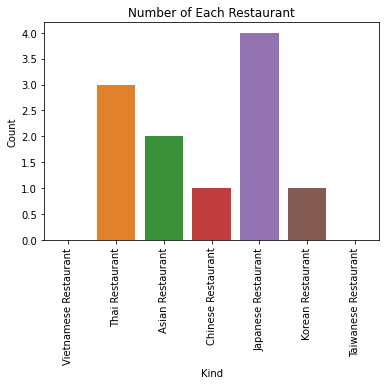

In [124]:
VisualizeCluster(cluster_0)

#### Cluster 1 (Chinese Neighborhoods)

In [103]:
cluster_1 = asia_merged.loc[asia_merged['Cluster Labels'] == 1]
cluster_1

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
38,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,1,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant
70,M9P,Etobicoke,Westmount,43.696319,-79.532242,1,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant
73,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,1,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant
90,M1W,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,1,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant


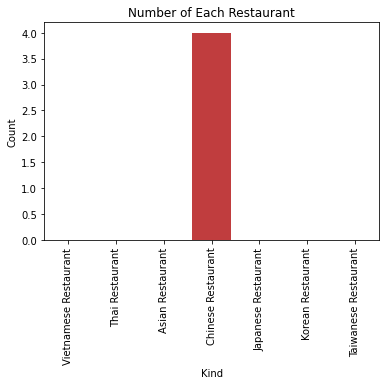

In [125]:
VisualizeCluster(cluster_1)

#### Cluster 2 (Outlier)

In [107]:
cluster_2 = asia_merged.loc[asia_merged['Cluster Labels'] == 2]
cluster_2

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
39,M2K,North York,Bayview Village,43.786947,-79.385975,2,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant


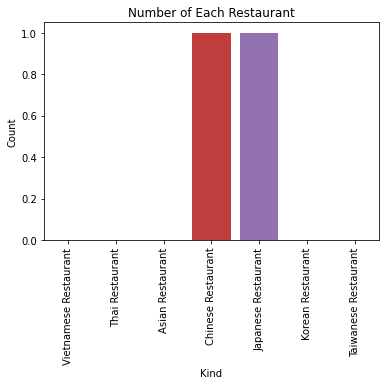

In [126]:
VisualizeCluster(cluster_2)

#### Cluster 3 (Thai Neighborhoods)

In [109]:
cluster_3 = asia_merged.loc[asia_merged['Cluster Labels'] == 3]
cluster_3

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
26,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
55,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,3,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
69,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,3,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
79,M4S,Central Toronto,Davisville,43.704324,-79.388790,3,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
82,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,3,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant


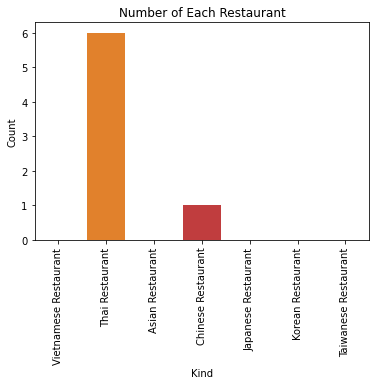

In [127]:
VisualizeCluster(cluster_3)

#### Cluster 4 (Asia Neighborhoods)

In [111]:
cluster_4 = asia_merged.loc[asia_merged['Cluster Labels'] == 4]
cluster_4

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant
7,M3B,North York,Don Mills,43.745906,-79.352188,4,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Thai Restaurant,Japanese Restaurant,Vietnamese Restaurant,Chinese Restaurant,Asian Restaurant
13,M3C,North York,Don Mills,43.725900,-79.340923,4,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,4,Asian Restaurant,Japanese Restaurant,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,4,Japanese Restaurant,Asian Restaurant,Vietnamese Restaurant,Thai Restaurant,Chinese Restaurant
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,4,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant,Korean Restaurant,Thai Restaurant
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,4,Asian Restaurant,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant
43,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,4,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant


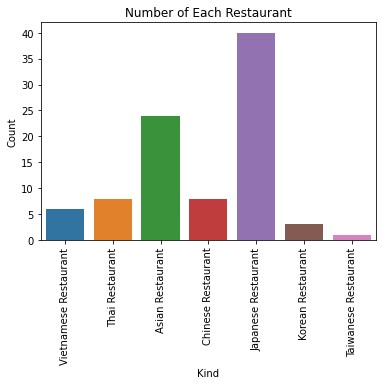

In [128]:
VisualizeCluster(cluster_4)

#### Cluster 5 (Outlier)

In [114]:
cluster_5 = asia_merged.loc[asia_merged['Cluster Labels'] == 5]
cluster_5

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
65,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.75741,-79.273304,5,Vietnamese Restaurant,Chinese Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant


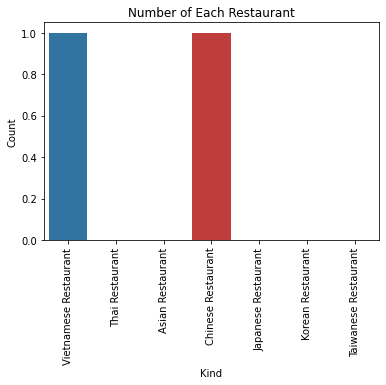

In [129]:
VisualizeCluster(cluster_5)

### Cluster 6 (Vietnamese Neighborhoods)

In [132]:
cluster_6 = asia_merged.loc[asia_merged['Cluster Labels'] == 6]
cluster_6

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,6,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant
86,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,6,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Chinese Restaurant,Japanese Restaurant


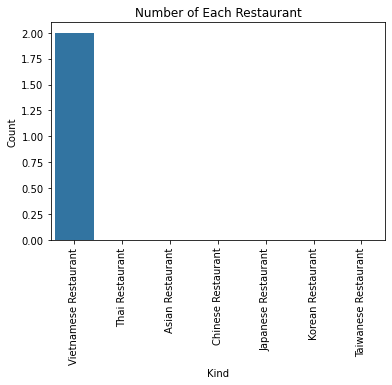

In [131]:
VisualizeCluster(cluster_6)

## Discussion
Looking at the venues nearby, the optimal place to put a new Vietnamese restaurants are cluster **1** and **3**. 

Cluster 1 is Chinese Neighborhoods and Cluster 3 is Thai Neighborhhods, they both have any Vietnamese restaurant, therefore, eliminating any competition. Moreover, China and Thailand are Vietnam neighbor countries that they may have some similarities in food.

Some of the drawbacks of this analysis are — the clustering is completely based on data obtained from the Foursquare API. Also, the analysis does not take into consideration of the Vietnamese population across neighbourhoods as this can play a huge factor while choosing which place to open a new Vietnamese restaurant. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Vietnamese restaurant in these locations with little to no competition.

## Conclusion
In conclusion, to end off this project, we had an opportunity on a business problem, and it was tackled in a way that it was similar to how a genuine data scientist would do. We utilized numerous Python libraries to fetch the information, control the content and break down and visualize those datasets. We have utilized Foursquare API to investigate the settings in neighbourhoods of Toronto, get a great measure of data from Wikipedia which we scraped with the Beautifulsoup Web scraping Library. We also visualized utilizing different plots present in seaborn and Matplotlib libraries. Similarly, we applied AI strategy to anticipate the error given the information and utilized Folium to picture it on a map.
Places that have room for improvement or certain drawbacks give us that this project can be additionally improved with the assistance of more information and distinctive Machine Learning strategies. Additionally, we can utilize this venture to investigate any situation, for example, opening an alternate cuisine or opening of a Movie Theater and so forth. Ideally, this task acts as an initial direction to tackle more complex real-life problems using data science.